O modelo Multi-Task Learning é composto por uma ou mais tarefas que são treinadas de forma conjunta. O modelo aqui desenvolvido é o MTL-POI e são treinadas duas tarefas de forma conjunta, ou seja, dois modelos Single-Task:

*   NPC -> NextPoiCat
*   PCat -> PoiCategorization

### **Bibliotecas**

In [1]:
import pandas as pd
import geopandas
import numpy as np
import copy
import os
from typing import Iterator

from calflops import calculate_flops

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import ast
import math
import random
import time
import datetime
import itertools
from itertools import cycle
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

/Users/vitor/Desktop/mestrado/ingred/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vitor/Desktop/mestrado/ingred/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Configurações**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Treinamento usando GPU.")
else:
    print("Treinamento usando CPU.")

Treinamento usando CPU.


In [3]:
seed = 18
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### **Definição dos *paths* das entradas**

In [4]:
# alabama
path_nextpoi_input_alabama = '/Users/vitor/Desktop/mestrado/ingred/data/alabama/nextpoi-input.csv'
path_categorypoi_input_alabama = '/Users/vitor/Desktop/mestrado/ingred/data/alabama/categorypoi-input.csv'

#### **Inicialização do MlFlow**

### **Funções utilitárias**

#### **Imprimir métricas**

In [5]:
id_to_name = {
    '0': 'Community',
    '1': 'Entertainment',
    '2': 'Food',
    '3': 'Nightlife',
    '4': 'Outdoors',
    '5': 'Shopping',
    '6': 'Travel'
}

In [6]:
def print_classification_report_train(y_true_category, y_pred_category, y_true_next, y_pred_next, id_to_name):
    category_report = classification_report(y_true_category, y_pred_category, zero_division=1, output_dict=True)
    next_report = classification_report(y_true_next, y_pred_next, zero_division=1, output_dict=True)

    category_df = pd.DataFrame(category_report).transpose()
    next_df = pd.DataFrame(next_report).transpose()

    category_df = category_df.drop(columns='support')
    category_df = category_df.drop(index=['weighted avg', 'accuracy'])

    next_df = next_df.drop(columns='support')
    next_df = next_df.drop(index=['weighted avg', 'accuracy'])

    category_df.rename(index=id_to_name, inplace=True)
    next_df.rename(index=id_to_name, inplace=True)

    category_df = category_df.transpose()
    next_df = next_df.transpose()

    category_df = category_df.map(lambda x: f"{x * 100:.1f}")
    next_df = next_df.map(lambda x: f"{x * 100:.1f}")

    print("\ncategory train metrics:")
    print(category_df.to_string())

    print("\n next train metrics:")
    print(next_df.to_string())

In [7]:
def print_classification_report_test(y_true, y_pred, id_to_name, task_name):
    report = classification_report(y_true, y_pred, zero_division=1, output_dict=True)

    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(columns='support')
    metrics_df = metrics_df.drop(index=['weighted avg', 'accuracy'])

    metrics_df.rename(index=id_to_name, inplace=True)
    metrics_df = metrics_df.transpose()

    metrics_df = metrics_df.map(lambda x: f"{x * 100:.1f}")

    print(f'{task_name} test metrics:')
    print(metrics_df.to_string() + '\n')

In [8]:
def print_classification_report_val(y_true, y_pred, id_to_name, task_name):
    report = classification_report(y_true, y_pred, zero_division=1, output_dict=True)

    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(columns='support')
    metrics_df = metrics_df.drop(index=['weighted avg', 'accuracy'])

    metrics_df.rename(index=id_to_name, inplace=True)
    metrics_df = metrics_df.transpose()

    metrics_df = metrics_df.map(lambda x: f"{x * 100:.1f}")

    print(f'validação {task_name} metrics:')
    print(metrics_df.to_string() + '\n')

#### **Imprimir perdas**

In [9]:
def print_train_losses(epoch, num_epochs, mtl_loss, next_loss, category_losss):
  print(f'\nEPOCH {epoch + 1}/{num_epochs}:')
  print(f'mtl loss: {mtl_loss:.1f}')
  print(f'next loss: {next_loss:.1f}')
  print(f'category loss: {category_losss:.1f}')

In [10]:
def print_val_losses(next_loss, category_losss):
  print(f'\nVALIDATION LOSSES:')
  print(f'next val loss: {next_loss:.1f}')
  print(f'category val loss: {category_losss:.1f}\n')

#### **Cálculo das métricas**

In [11]:
def calculate_metrics_by_fold(fold_results, task_name):
    metrics = {
        'fold': [],
        'precision': [],
        'recall': [],
        'f1-score': []
    }

    for fold, results in fold_results.items():
        y_true = results[f'test_{task_name}_true']
        y_pred = results[f'test_{task_name}_pred']

        report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

        metrics['fold'].append(fold)
        metrics['precision'].append(report['macro avg']['precision'])
        metrics['recall'].append(report['macro avg']['recall'])
        metrics['f1-score'].append(report['macro avg']['f1-score'])

    return pd.DataFrame(metrics)

### **Input do modelo MTL**

In [12]:
def x_y_to_tensor(x, y, task_name):
  x = torch.tensor(x.values, dtype=torch.float)
  y = torch.tensor(y.values, dtype=torch.long)

  if task_name == 'next':
     x = x.view(-1, 9, 100)
  else:
     x = x.view(-1, 1, 100)


  x.to(device)
  y.to(device)

  return x, y

def map_categories(y):
  id_to_name = {
    '0': 'Community',
    '1': 'Entertainment',
    '2': 'Food',
    '3': 'Nightlife',
    '4': 'Outdoors',
    '5': 'Shopping',
    '6': 'Travel',
    '7': 'None'
  }

  name_to_id = {name: int(id) for id, name in id_to_name.items()}
  try:
    y_encoded = np.array([[name_to_id[yi] for yi in row] for _, row in y.iterrows()])
  except:
    y_encoded = y.map(name_to_id)

  return y_encoded

#### **Input do modelo NPC**

In [13]:
df_nextpoi_input = pd.read_csv(path_nextpoi_input_alabama)
print(df_nextpoi_input.shape)

usersids = df_nextpoi_input['userid'].unique().size
print(usersids)

(8637, 910)
418


In [14]:
target = df_nextpoi_input.columns[900:-1]

x_nextpoi = df_nextpoi_input.drop(target, axis=1)
y_nextpoi = df_nextpoi_input[target]
y_nextpoi = y_nextpoi.fillna('None')
y_nextpoi = map_categories(y_nextpoi)
y_nextpoi = pd.DataFrame(y_nextpoi)
print(x_nextpoi.shape, y_nextpoi.shape)

(8637, 901) (8637, 9)


#### **Input do modelo PCat**

In [15]:
categorypoi_input = pd.read_csv(path_categorypoi_input_alabama)
print(categorypoi_input.shape)

placesids = categorypoi_input['placeid'].unique()
placesids = placesids.astype(int)
print(len(placesids))

categorypoi_input = categorypoi_input.set_index('placeid')
print(categorypoi_input.shape)

(9090, 102)
9090
(9090, 101)


In [16]:
x_categorypoi = categorypoi_input.drop('category', axis=1)
y_categorypoi = categorypoi_input['category']

y_categorypoi = map_categories(y_categorypoi)

print(x_categorypoi.shape, y_categorypoi.shape)

(9090, 100) (9090,)


### **Definição dos Dataset e Dataloaders**

In [17]:
class CustomDataset(Dataset):
    def __init__(self, input_features, true_y):
        self.input_features = input_features
        self.true_y = true_y

    def __len__(self):
        return len(self.input_features)

    def __getitem__(self, idx):
        sample = {
            'x': self.input_features[idx],
            'y': self.true_y[idx]
        }
        return sample

In [18]:
def input_to_dataloader(x, y, batch_size=32, shuffle=True):
  dataset = CustomDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return dataloader

### **Otimizador**

Nessa parte você só precisa adicionar o otimizador que você vai testar. Deixei a definição do PCGrad de exemplo aqui pra você mas qualquer coisa é só me chamar!

In [19]:
from typing import Dict, List, Tuple, Union
from abc import abstractmethod

class WeightMethod:
    def __init__(self, n_tasks: int, device: torch.device):
        super().__init__()
        self.n_tasks = n_tasks
        self.device = device

    @abstractmethod
    def get_weighted_loss(
        self,
        losses: torch.Tensor,
        shared_parameters: Union[List[torch.nn.parameter.Parameter], torch.Tensor],
        task_specific_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ],
        last_shared_parameters: Union[List[torch.nn.parameter.Parameter], torch.Tensor],
        representation: Union[torch.nn.parameter.Parameter, torch.Tensor],
        **kwargs,
    ):
        pass

    def backward(
        self,
        losses: torch.Tensor,
        shared_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
        task_specific_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
        last_shared_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
        representation: Union[List[torch.nn.parameter.Parameter], torch.Tensor] = None,
        **kwargs,
    ) -> Tuple[Union[torch.Tensor, None], Union[dict, None]]:
        """

        Parameters
        ----------
        losses :
        shared_parameters :
        task_specific_parameters :
        last_shared_parameters : parameters of last shared layer/block
        representation : shared representation
        kwargs :

        Returns
        -------
        Loss, extra outputs
        """
        loss, extra_outputs = self.get_weighted_loss(
            losses=losses,
            shared_parameters=shared_parameters,
            task_specific_parameters=task_specific_parameters,
            last_shared_parameters=last_shared_parameters,
            representation=representation,
            **kwargs,
        )
        loss.backward()
        return loss, extra_outputs

    def __call__(
        self,
        losses: torch.Tensor,
        shared_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
        task_specific_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
        **kwargs,
    ):
        return self.backward(
            losses=losses,
            shared_parameters=shared_parameters,
            task_specific_parameters=task_specific_parameters,
            **kwargs,
        )

    def parameters(self) -> List[torch.Tensor]:
        """return learnable parameters"""
        return []

In [20]:
class PCGrad(WeightMethod):
    """Modification of: https://github.com/WeiChengTseng/Pytorch-PCGrad/blob/master/pcgrad.py

    @misc{Pytorch-PCGrad,
      author = {Wei-Cheng Tseng},
      title = {WeiChengTseng/Pytorch-PCGrad},
      url = {https://github.com/WeiChengTseng/Pytorch-PCGrad.git},
      year = {2020}
    }

    """

    def __init__(self, n_tasks: int, device: torch.device, reduction="sum"):
        super().__init__(n_tasks, device=device)
        assert reduction in ["mean", "sum"]
        self.reduction = reduction

    def get_weighted_loss(
        self,
        losses: torch.Tensor,
        shared_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
        task_specific_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
        **kwargs,
    ):
        raise NotImplementedError

    def _set_pc_grads(self, losses, shared_parameters, task_specific_parameters=None):
        # shared part
        shared_grads = []
        for l in losses:
            shared_grads.append(
                torch.autograd.grad(l, shared_parameters, retain_graph=True, allow_unused=True)
            )

        if isinstance(shared_parameters, torch.Tensor):
            shared_parameters = [shared_parameters]
        non_conflict_shared_grads = self._project_conflicting(shared_grads)
        for p, g in zip(shared_parameters, non_conflict_shared_grads):
            p.grad = g

        # task specific part
        if task_specific_parameters is not None:
            task_specific_grads = torch.autograd.grad(
                losses.sum(), task_specific_parameters
            )
            if isinstance(task_specific_parameters, torch.Tensor):
                task_specific_parameters = [task_specific_parameters]
            for p, g in zip(task_specific_parameters, task_specific_grads):
                p.grad = g

    def _project_conflicting(self, grads: List[Tuple[torch.Tensor]]):
        pc_grad = copy.deepcopy(grads)
        for g_i in pc_grad:
            random.shuffle(grads)
            for g_j in grads:
                g_i_g_j = sum(
                    [
                        torch.dot(torch.flatten(grad_i), torch.flatten(grad_j))
                        for grad_i, grad_j in zip(g_i, g_j)
                    ]
                )
                if g_i_g_j < 0:
                    g_j_norm_square = (
                        torch.norm(torch.cat([torch.flatten(g) for g in g_j])) ** 2
                    )
                    for grad_i, grad_j in zip(g_i, g_j):
                        grad_i -= g_i_g_j * grad_j / g_j_norm_square

        merged_grad = [sum(g) for g in zip(*pc_grad)]
        if self.reduction == "mean":
            merged_grad = [g / self.n_tasks for g in merged_grad]

        return merged_grad

    def backward(
        self,
        losses: torch.Tensor,
        parameters: Union[List[torch.nn.parameter.Parameter], torch.Tensor] = None,
        shared_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
        task_specific_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
        **kwargs,
    ):
        self._set_pc_grads(losses, shared_parameters, task_specific_parameters)
        return None, {}  # NOTE: to align with all other weight methods

### **Arquitetura do modelo**

#### **Arquitetura do modelo NPC**

In [21]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_seq_length=5000, dropout=0.1):
        """
        Args:
            embed_dim: The dimensionality of the embedding space.
            max_seq_length: The maximum sequence length to handle.
            dropout: Dropout rate applied to positional encodings.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        positional_encoding = torch.zeros(max_seq_length, embed_dim)
        positions = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))

        positional_encoding[:, 0::2] = torch.sin(positions * div_term)
        positional_encoding[:, 1::2] = torch.cos(positions * div_term)

        positional_encoding = positional_encoding.unsqueeze(0)

        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_length, embed_dim).
        Returns:
            Tensor with positional encodings added to the input embeddings.
        """
        seq_length = x.size(1)
        x = x + self.positional_encoding[:, :seq_length, :]
        return self.dropout(x)


In [22]:
class NextPoinet(nn.Module):
    def __init__(self, embed_dim, num_classes, num_heads, seq_length, num_layers, dropout=0.1):
        super(NextPoinet, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.seq_length = seq_length
        self.pe = PositionalEncoding(embed_dim, 9)
        encoder_layer = nn.TransformerEncoderLayer(
            embed_dim,
            num_heads,
            dim_feedforward=embed_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.linear_layers = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.pe(x)
        batch_size, seq_length, _ = x.size()

        attn_mask = torch.triu(torch.ones(seq_length, seq_length) * float('-inf'), diagonal=1).to(x.device)

        x = self.transformer_encoder(x, mask=attn_mask)

        x = self.linear_layers(x)

        return x

#### **Arquitetura do modelo PCat**

In [23]:
class CategoryPoinet(nn.Module):
    def __init__(self, num_classes):
        super(CategoryPoinet, self).__init__()

        self.linear = nn.Linear(256, 484)
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(256, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.linear(x)
        b, seq, dim = x.shape
        dim = int(dim ** 0.5)
        x = x.view(b, seq, dim, dim)

        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.view(b, seq, -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out

#### **Arquitetura do modelo MTL-POI**

In [24]:
class MTLnet(nn.Module):
    def __init__(self, feature_size, shared_layer_size, num_classes, num_heads, num_layers, seq_length, num_shared_layers):
        super(MTLnet, self).__init__()
        self.num_classes = num_classes
        self.feature_size = feature_size
        self.embedding = torch.nn.Embedding(1, feature_size)

        shared_linear_layers = [] # lista de layers compartilhadas

         # add primeira camada de input (feature_size -> shared_layer_size)
        shared_linear_layers.append(nn.Linear(feature_size, shared_layer_size))
        shared_linear_layers.append(nn.LeakyReLU())
        shared_linear_layers.append(nn.Dropout())

        # add layers intermediarias
        for _ in range(num_shared_layers - 1):
            shared_linear_layers.append(nn.Linear(shared_layer_size, shared_layer_size))
            shared_linear_layers.append(nn.LeakyReLU())
            shared_linear_layers.append(nn.Dropout())

        # cria o sequential igual antes
        self.shared_layers = nn.Sequential(*shared_linear_layers)

        self.category_poi = CategoryPoinet(num_classes)
        self.next_poi = NextPoinet(shared_layer_size, num_classes, num_heads, seq_length, num_layers)

    def forward(self, x1, x2):
        idxs = x2.sum(-1) == 0

        if torch.any(idxs):
          replace_tensor = self.embedding(torch.tensor(0, dtype=torch.long).to(device))
          x2[idxs] = replace_tensor

        shared_output1 = self.shared_layers(x1)
        shared_output2 = self.shared_layers(x2)

        out1 = self.category_poi(shared_output1)
        out2 = self.next_poi(shared_output2)

        out1 = out1.view(-1, self.num_classes)

        return out1, out2

    def forward_nextpoi(self, x):
        idxs = x.sum(-1) == 0
        x[idxs] = self.embedding(torch.tensor(0,dtype=torch.long).to(device))

        shared_output = self.shared_layers(x)

        out = self.next_poi(shared_output)

        return out

    def forward_categorypoi(self, x):
        shared_output = self.shared_layers(x)

        out = self.category_poi(shared_output)

        out = out.view(-1, self.num_classes)

        return out

### **Cálculo do FLOPs do modelo**

In [25]:
model = MTLnet(
      feature_size=100,
      shared_layer_size=256,
      num_classes=7,
      num_heads=8,
      num_layers=4,
      seq_length=9,
      num_shared_layers=4,
    )

model = model.to(device)

/Users/vitor/Desktop/mestrado/ingred/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [26]:
x_nextpoi_ = x_nextpoi.copy()
x_nextpoi_.userid = x_nextpoi_.userid.astype(int)
usersids = x_nextpoi_['userid'].unique()

train_user_index, test_user_index = train_test_split(usersids, test_size=0.25, random_state=42)

train_place_index, test_place_index = train_test_split(x_categorypoi.index, test_size=0.25, random_state=42)

train_user_index, val_user_index = train_test_split(train_user_index, test_size=0.25, random_state=42)
train_place_index, val_place_index = train_test_split(train_place_index, test_size=0.25, random_state=42)

train_index_next = x_nextpoi_[x_nextpoi_['userid'].isin(train_user_index)].index
x_nextpoi_ = x_nextpoi_.drop('userid', axis=1)

y_nextpoi_ = y_nextpoi.copy()
x_nextpoi_, y_nextpoi_ = x_y_to_tensor(x_nextpoi_, y_nextpoi_, 'next')
x_train_next = x_nextpoi_[train_index_next]
y_train_next = y_nextpoi_[train_index_next]

x_categorypoi_ = x_categorypoi.copy()
y_categorypoi_ = y_categorypoi.copy()
x_categorypoi_, y_categorypoi_ = x_y_to_tensor(x_categorypoi_, y_categorypoi_, 'category')

if isinstance(x_categorypoi_, torch.Tensor):
    train_place_index, test_place_index = train_test_split(torch.arange(x_categorypoi_.size(0)), test_size=0.25, random_state=42)
    train_place_index, val_place_index = train_test_split(train_place_index, test_size=0.25, random_state=42)

    x_train_category = x_categorypoi_[train_place_index]
    y_train_category = y_categorypoi_[train_place_index]

    x_test_category = x_categorypoi_[test_place_index]
    y_test_category = y_categorypoi_[test_place_index]

    x_val_category = x_categorypoi_[val_place_index]
    y_val_category = y_categorypoi_[val_place_index]
else:
    raise TypeError("x_categorypoi should be a tensor")

next_dataloader_train = input_to_dataloader(x_train_next, y_train_next)
category_dataloader_train = input_to_dataloader(x_train_category, y_train_category)

In [27]:
print("Tamanho de x_categorypoi:", x_categorypoi.shape[0])
print("train_place_index:", train_place_index)
print("test_place_index:", test_place_index)
print("val_place_index:", val_place_index)
print(type(x_categorypoi))

Tamanho de x_categorypoi: 9090
train_place_index: tensor([2941, 4620, 7943,  ..., 4455, 7486, 8697])
test_place_index: tensor([3290, 2554, 3065,  ..., 4165, 3307, 1302])
val_place_index: tensor([8328, 4452, 4330,  ..., 1453, 1439, 5042])
<class 'pandas.core.frame.DataFrame'>


In [28]:
first_batch_nextpoi = next(iter(next_dataloader_train))
x1 = first_batch_nextpoi['x']

first_batch_categorypoi = next(iter(category_dataloader_train))
x2 = first_batch_categorypoi['x']

x1 = x1.to(device)
x2 = x2.to(device)

In [29]:
flops, macs, params = calculate_flops(model=model,
                                          kwargs={'x1': x2, 'x2': x1},
                                          print_results=False)

print("MTL-Poi FLOPs: %s   MACs: %s   Params: %s" %(flops, macs, params))

flops = {
        'flops': flops,
        'macs': macs,
        'params': params,
}

MTL-Poi FLOPs: 1.38 GFLOPS   MACs: 687.28 MMACs   Params: 2.03 M


### **Treinamento e teste do modelo**

#### **Definição da função de validação**

In [30]:
def val_model(model, loss_function, one_hot, dataloader, id_to_name, task_name):
  y_true = []
  y_pred = []
  running_loss = 0.0
  steps = 0

  model.eval()

  with torch.no_grad():
      for data in dataloader:
          x, y = data['x'], data['y']
          x = x.to(device)
          y = y.to(device)

          if task_name == 'next':
            out = model.forward_nextpoi(x)

            B, S, _ = out.shape
            out = out.view(B * S , -1)
            y = y.view(B * S , -1)

            valid_samples = y < 7
            expanded_mask = valid_samples.expand(-1, out.shape[1])

            y = y[valid_samples]
            out = out[expanded_mask].view(-1, 7)

            predicted = torch.argmax(out, dim=-1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())

            # y_one_hot = one_hot[y]
            loss = loss_function(out, y)
            running_loss += loss.item()
            steps += 1

          else:
            out = model.forward_categorypoi(x)

            predicted = torch.argmax(out, dim=-1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())

            y_one_hot = one_hot[y]
            loss = loss_function(out, y_one_hot)
            running_loss += loss.item()
            steps += 1

  average_loss = running_loss / steps if steps > 0 else 0.0

  print_classification_report_val(y_true, y_pred, id_to_name, task_name)

  return y_true, y_pred, average_loss

#### **Definição da função de teste**

In [31]:
def test_model(model, dataloader, id_to_name, task_name):
  print(f'\nTESTE {task_name.upper()}\n')

  y_true = []
  y_pred = []

  model.eval()

  with torch.no_grad():
      for data in dataloader:
          x, y = data['x'], data['y']
          x = x.to(device)
          y = y.to(device)

          if task_name == 'next':
            out = model.forward_nextpoi(x)
          else:
            out = model.forward_categorypoi(x)

          predicted = torch.argmax(out, dim=-1)

          valid_samples = y < 7

          y = y[valid_samples]
          predicted = predicted[valid_samples]

          y_true.extend(y.view(-1).tolist())
          y_pred.extend(predicted.view(-1).tolist())

      print_classification_report_test(y_true, y_pred, id_to_name, task_name)
      print()

  return y_true, y_pred

#### **Definição da função de treino**

In [32]:
def train_model_by_fold(model, optimizer, scheduler, next_dataloader_train, category_dataloader_train, next_dataloader_val,
                        category_dataloader_val, loss_function, one_hot, num_epochs, id_to_name, print_interval=1):
    mtl_train_losses = []
    next_losses = []
    category_losses = []
    next_val_losses = []
    category_val_losses = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pcgrad = PCGrad(n_tasks=2, device=device, reduction="sum")

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        next_running_loss = 0.0
        category_running_loss = 0.0
        max_norm = 1.0

        y_true_category = []
        y_pred_category = []
        y_true_next = []
        y_pred_next = []

        steps = 0
        category_iter = cycle(category_dataloader_train)

        for data_next in next_dataloader_train:
            data_category = next(category_iter)
            optimizer.zero_grad()

            x_next, y_next = data_next['x'], data_next['y']

            x_next = x_next.to(device)
            y_next = y_next.to(device)

            x_category, y_category = data_category['x'], data_category['y']
            x_category = x_category.to(device)
            y_category = y_category.to(device)
            out_category, out_next = model(x_category, x_next)

            category_predicted = torch.argmax(out_category, dim=-1)

            y_true_category.extend(y_category.tolist())
            y_pred_category.extend(category_predicted.tolist())

            B, S, _ = out_next.shape

            out_next = out_next.view(B * S , -1)
            y_next = y_next.view(B * S , -1)

            idx_valid = (y_next < num_classes).view(-1)
            y_next = y_next[idx_valid].view(-1)
            out_next = out_next[idx_valid]


            next_predicted = torch.argmax(out_next, dim=-1)

            y_true_next.extend(y_next.tolist())
            y_pred_next.extend(next_predicted.view(-1).tolist())

            out_next = out_next.view(-1, num_classes)


            loss_next = loss_function(out_next, y_next)
            loss_category = loss_function(out_category, y_category.view(-1))
            loss = loss_next + loss_category

            #aplicar pcgrad
            loss_next.backward(retain_graph=True)
            loss_category.backward(retain_graph=True)

            pcgrad.backward(
            losses=torch.stack([loss_next, loss_category]),
            shared_parameters=list(model.shared_layers.parameters()),
            # shared_parameters=list(model.shared_parameters()),
            # task_specific_parameters=list(model.task_specific_parameters())
            )

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            steps += 1
            running_loss += loss.item()
            next_running_loss += loss_next.item()
            category_running_loss += loss_category.item()

        if steps > 0:
            if (epoch + 1) % print_interval == 0 or epoch == 0:
                mtl_loss_by_epoch = running_loss / steps
                next_loss_by_epoch = next_running_loss / steps
                category_loss_by_epoch = category_running_loss / steps

                mtl_train_losses.append(mtl_loss_by_epoch)
                next_losses.append(next_loss_by_epoch)
                category_losses.append(category_loss_by_epoch)
                print_train_losses(epoch, num_epochs, mtl_loss_by_epoch, next_loss_by_epoch, category_loss_by_epoch)
                print_classification_report_train(y_true_category, y_pred_category, y_true_next, y_pred_next, id_to_name)
                print()
                print("-" * 110)
                print()

                model.eval()

                # validação category
                val_y_true_category, val_y_pred_category, category_val_loss = val_model(model, loss_function, one_hot, category_dataloader_val, id_to_name, 'category')
                category_val_losses.append(category_val_loss)

                # validação next
                val_y_true_next, val_y_pred_next, next_val_loss = val_model(model, loss_function, one_hot, next_dataloader_val, id_to_name, 'next')
                next_val_losses.append(next_val_loss)
                print("*" * 110)

                print_val_losses(next_val_loss, category_val_loss)

                scheduler.step(mtl_loss_by_epoch)

    results = {'mtl_train_losses': mtl_train_losses,
               'next_losses': next_losses,
               'category_losses': category_losses,
               'next_val_losses': next_val_losses,
               'category_val_losses': category_val_losses,
               'y_true_category': y_true_category,
               'y_pred_category': y_pred_category,
               'y_true_next': y_true_next,
               'y_pred_next': y_pred_next,
               'val_y_true_category': val_y_true_category,
               'val_y_pred_category': val_y_pred_category,
               'val_y_true_next': val_y_true_next,
               'val_y_pred_next': val_y_pred_next
               }
    return results

#### **Treinamento do modelo com validação cruzada**

In [34]:
num_classes = 7
num_epochs = 50
fold = 1
print_interval = 1
learning_rate = 0.0001

kf = KFold(n_splits=5, shuffle=True, random_state=42)
one_hot = torch.eye(num_classes).to(device)

try:
  x_nextpoi.userid = x_nextpoi.userid.astype(int)
  usersids = x_nextpoi['userid'].unique()
except:
  pass

fold_results_test = {}
fold_results_train = {}
fold_losses_train = {}
fold_results_val = {}
fold_losses_val = {}

for (train_user_index, test_user_index), (train_place_index, test_place_index) in zip(kf.split(usersids), kf.split(x_categorypoi)):
    print("#" * 110)
    print(f'FOLD {fold}:')

    try:
      x_nextpoi = _x_nextpoi.copy()
      y_nextpoi = _y_nextpoi.copy()
      x_categorypoi = _x_categorypoi.copy()
      y_categorypoi = _y_categorypoi.copy()
    except:
      _x_nextpoi = x_nextpoi.copy()
      _y_nextpoi = y_nextpoi.copy()
      _x_categorypoi = x_categorypoi.copy()
      _y_categorypoi = y_categorypoi.copy()

    model = MTLnet(
      feature_size=100,
      shared_layer_size=256,
      num_classes=num_classes,
      num_heads=8,
      num_layers=4,
      seq_length=9,
      num_shared_layers=4,
    )

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # val e train
    train_user_index, val_user_index = train_test_split(train_user_index, test_size=0.25, random_state=42)
    train_place_index, val_place_index = train_test_split(train_place_index, test_size=0.25, random_state=42)

    # indexs para o split pro nextpoi
    train_index_next = x_nextpoi[x_nextpoi['userid'].isin(usersids[train_user_index])].index
    val_index_next = x_nextpoi[x_nextpoi['userid'].isin(usersids[val_user_index])].index
    test_index_next = x_nextpoi[x_nextpoi['userid'].isin(usersids[test_user_index])].index
    x_nextpoi = x_nextpoi.drop('userid', axis=1)

    # train, test e val pro nextpoi
    x_nextpoi, y_nextpoi = x_y_to_tensor(x_nextpoi, y_nextpoi, 'next')
    x_train_next, x_test_next, x_val_next = x_nextpoi[train_index_next], x_nextpoi[test_index_next], x_nextpoi[val_index_next]
    y_train_next, y_test_next, y_val_next = y_nextpoi[train_index_next], y_nextpoi[test_index_next], y_nextpoi[val_index_next]

    # train, test e val pro categorypoi
    x_categorypoi, y_categorypoi = x_y_to_tensor(x_categorypoi, y_categorypoi, 'category')
    x_train_category, x_test_category, x_val_category = x_categorypoi[train_place_index], x_categorypoi[test_place_index], x_categorypoi[val_place_index]
    y_train_category, y_test_category, y_val_category = y_categorypoi[train_place_index], y_categorypoi[test_place_index], y_categorypoi[val_place_index]

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_category.cpu().numpy()), y=y_train_category.cpu().numpy())
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    loss_function = nn.CrossEntropyLoss(weight=class_weights)
    loss_function_PCatEncoder = nn.MSELoss()

    # dataloaders nextpoi
    next_dataloader_train = input_to_dataloader(x_train_next, y_train_next)
    next_dataloader_test = input_to_dataloader(x_test_next, y_test_next)
    next_dataloader_val = input_to_dataloader(x_val_next, y_val_next)

    # dataloaders categorypoi
    category_dataloader_train = input_to_dataloader(x_train_category, y_train_category)
    category_dataloader_test = input_to_dataloader(x_test_category, y_test_category)
    category_dataloader_val = input_to_dataloader(x_val_category, y_val_category)

    fold_results_test[fold] = {
        'test_next_true': [],
        'test_next_pred': [],
        'test_category_true': [],
        'test_category_pred': []
    }

    fold_results_train[fold] = {
        'train_next_true': [],
        'train_next_pred': [],
        'train_category_true': [],
        'train_category_pred': [],
    }

    fold_results_val[fold] = {
        'val_next_true': [],
        'val_next_pred': [],
        'val_category_true': [],
        'val_category_pred': [],
    }

    fold_losses_train[fold] = {
        'mtl_train_losses': [],
        'next_losses': [],
        'category_losses': []
    }

    fold_losses_val[fold] = {
        'next_val_losses': [],
        'category_val_losses': [],
    }

    # train mtl model
    results = train_model_by_fold(model, optimizer, scheduler, next_dataloader_train, category_dataloader_train,
                                  next_dataloader_val, category_dataloader_val,
                                  loss_function, one_hot, num_epochs, id_to_name)

    fold_losses_train[fold]['mtl_train_losses'] = results['mtl_train_losses']
    fold_losses_train[fold]['next_losses'] = results['next_losses']
    fold_losses_train[fold]['category_losses'] = results['category_losses']

    fold_losses_val[fold]['next_val_losses'] = results['next_val_losses']
    fold_losses_val[fold]['category_val_losses'] = results['category_val_losses']

    fold_results_train[fold]['train_next_true'] = results['y_true_next']
    fold_results_train[fold]['train_next_pred'] = results['y_pred_next']
    fold_results_train[fold]['train_category_true'] = results['y_true_category']
    fold_results_train[fold]['train_category_pred'] = results['y_pred_category']

    fold_results_val[fold]['val_next_true'] = results['val_y_true_next']
    fold_results_val[fold]['val_next_pred'] = results['val_y_pred_next']
    fold_results_val[fold]['val_category_true'] = results['val_y_true_category']
    fold_results_val[fold]['val_category_pred'] = results['val_y_pred_category']

    # test next
    y_true_test_next, y_pred_test_next = test_model(model, next_dataloader_test, id_to_name, 'next')
    fold_results_test[fold]['test_next_true'] = y_true_test_next
    fold_results_test[fold]['test_next_pred'] = y_pred_test_next

    # test category
    y_true_test_category, y_pred_test_category = test_model(model, category_dataloader_test, id_to_name, 'category')
    fold_results_test[fold]['test_category_true'] = y_true_test_category
    fold_results_test[fold]['test_category_pred'] = y_pred_test_category

    fold += 1

##############################################################################################################
FOLD 1:


/Users/vitor/Desktop/mestrado/ingred/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 3.9
next loss: 2.0
category loss: 1.9

category train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      14.5         100.0  32.6     100.0      5.3    100.0    4.3      51.0
recall         29.0           0.0  26.3       0.0     44.9      0.0    0.4      14.4
f1-score       19.3           0.0  29.1       0.0      9.4      0.0    0.7       8.4

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      19.2           5.4  32.3       4.7      3.9     26.7    5.1      13.9
recall         24.1           7.2   7.6      44.2      3.3      3.0    9.8      14.2
f1-score       21.3           6.2  12.3       8.5      3.6      5.4    6.7       9.2

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Tra

/Users/vitor/Desktop/mestrado/ingred/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 3.9
next loss: 2.0
category loss: 1.9

category train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      13.3         100.0  32.7       0.0      5.0     34.0  100.0      40.7
recall          7.6           0.0  18.9       0.0     69.6      1.9    0.0      14.0
f1-score        9.7           0.0  24.0       0.0      9.4      3.6    0.0       6.7

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      23.1           5.3  35.6       4.4      4.2     25.5    4.4      14.6
recall         36.8           8.0   6.2      37.4      4.5      2.7    8.1      14.8
f1-score       28.4           6.4  10.6       7.9      4.4      5.0    5.7       9.7

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment   Food Nightlife Outdoors Shopping Tr

/Users/vitor/Desktop/mestrado/ingred/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 3.9
next loss: 2.0
category loss: 1.9

category train metrics:
          Community Entertainment   Food Nightlife Outdoors Shopping Travel macro avg
precision      14.6         100.0  100.0     100.0      3.8     33.3  100.0      64.5
recall         70.3           0.0    0.0       0.0      3.6     24.0    0.0      14.0
f1-score       24.1           0.0    0.0       0.0      3.7     27.9    0.0       8.0

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      20.6           4.6  35.2       5.4      5.4     29.2    4.7      15.0
recall         22.7           4.6   6.5      52.3      5.8      1.8   10.3      14.9
f1-score       21.6           4.6  11.0       9.8      5.6      3.3    6.4       8.9

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment   Food Nightlife Outdoors Shoppin

/Users/vitor/Desktop/mestrado/ingred/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 3.9
next loss: 2.0
category loss: 1.9

category train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision     100.0         100.0  34.1       1.4    100.0    100.0  100.0      76.5
recall          0.0           0.0  94.6       3.0      0.0      0.0    0.0      13.9
f1-score        0.0           0.0  50.1       1.9      0.0      0.0    0.0       7.4

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      20.7           6.4  34.6       4.3      4.3     30.0    4.8      15.0
recall         26.9           8.3   6.4      43.2      7.8      3.8    8.0      14.9
f1-score       23.4           7.2  10.8       7.8      5.5      6.8    6.0       9.6

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment   Food Nightlife Outdoors Shopping Tr

/Users/vitor/Desktop/mestrado/ingred/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



EPOCH 1/50:
mtl loss: 3.9
next loss: 2.0
category loss: 1.9

category train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      15.1         100.0  34.5       0.0    100.0    100.0  100.0      64.2
recall         34.2           0.0  67.9       0.0      0.0      0.0    0.0      14.6
f1-score       21.0           0.0  45.8       0.0      0.0      0.0    0.0       9.5

 next train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      22.5           6.1  33.6       5.4      4.4     29.0    3.6      14.9
recall         33.8           9.1   6.3      43.3      8.1      3.2    4.1      15.4
f1-score       27.0           7.3  10.6       9.6      5.7      5.7    3.8      10.0

--------------------------------------------------------------------------------------------------------------

validação category metrics:
          Community Entertainment   Food Nightlife Outdoors Shopping Tr

In [40]:
import pickle

# save in pickle
# fold_results_test = {}
# fold_results_train = {}
# fold_losses_train = {}
# fold_results_val = {}
# fold_losses_val = {}

with open('fold_results_test.pkl', 'wb') as f:
    pickle.dump(fold_results_test, f)

with open('fold_results_train.pkl', 'wb') as f:
    pickle.dump(fold_results_train, f)

with open('fold_losses_train.pkl', 'wb') as f:
    pickle.dump(fold_losses_train, f)

with open('fold_results_val.pkl', 'wb') as f:
    pickle.dump(fold_results_val, f)

with open('fold_losses_val.pkl', 'wb') as f:
    pickle.dump(fold_losses_val, f)


### **Análise dos resultados**

#### **Distribuição das métricas de teste**

##### **NPC**

In [35]:
metrics_df_next = calculate_metrics_by_fold(fold_results_test, 'next')
print('nextpoi test metrics by fold:\n')
print(metrics_df_next)

nextpoi test metrics by fold:

   fold  precision    recall  f1-score
0     1   0.238707  0.256317  0.216047
1     2   0.227116  0.249176  0.183752
2     3   0.219603  0.252440  0.200007
3     4   0.278336  0.292801  0.211650
4     5   0.265588  0.271951  0.218981


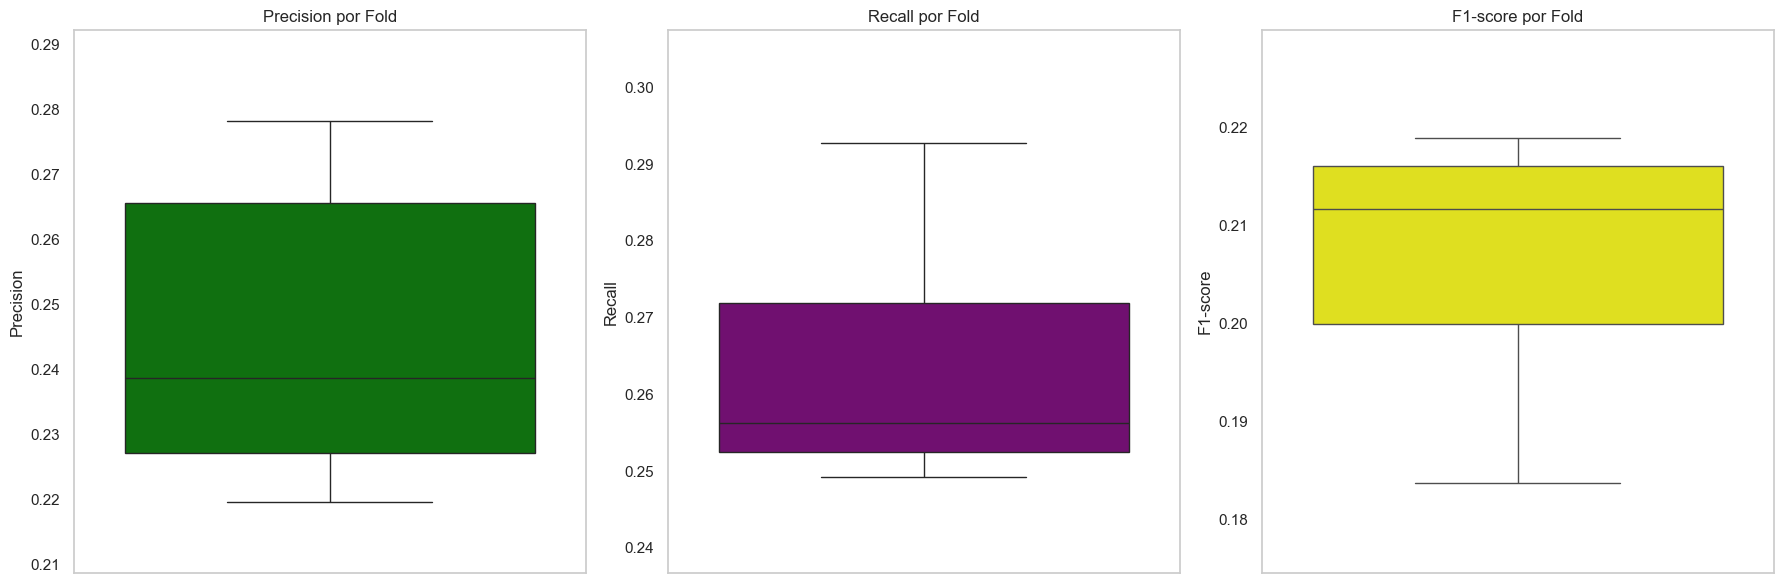

In [36]:
metrics = ['precision', 'recall', 'f1-score']
cores = ['green', 'purple', 'yellow']
plt.figure(figsize=(18, 6))

sns.set(style="whitegrid")

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=metric, data=metrics_df_next, color=cores[i])
    plt.title(f'{metric.capitalize()} por Fold')
    plt.ylabel(metric.capitalize())

    min_val = metrics_df_next[metric].min() * 0.95
    max_val = metrics_df_next[metric].max() * 1.05
    plt.ylim(min_val, max_val)

    plt.grid(False)

plt.tight_layout()

metric_by_fold_nextpoi = '/tmp/metric-by-fold-nextpoi.png'
plt.savefig(metric_by_fold_nextpoi)

plt.show()

##### **PCat**

In [37]:
metrics_df_category = calculate_metrics_by_fold(fold_results_test, 'category')
print('categorypoi test metrics by fold:\n')
print(metrics_df_category)

categorypoi test metrics by fold:

   fold  precision    recall  f1-score
0     1   0.345504  0.311337  0.285072
1     2   0.280153  0.309919  0.275905
2     3   0.277048  0.306412  0.269732
3     4   0.338725  0.311404  0.264372
4     5   0.328261  0.301849  0.289661


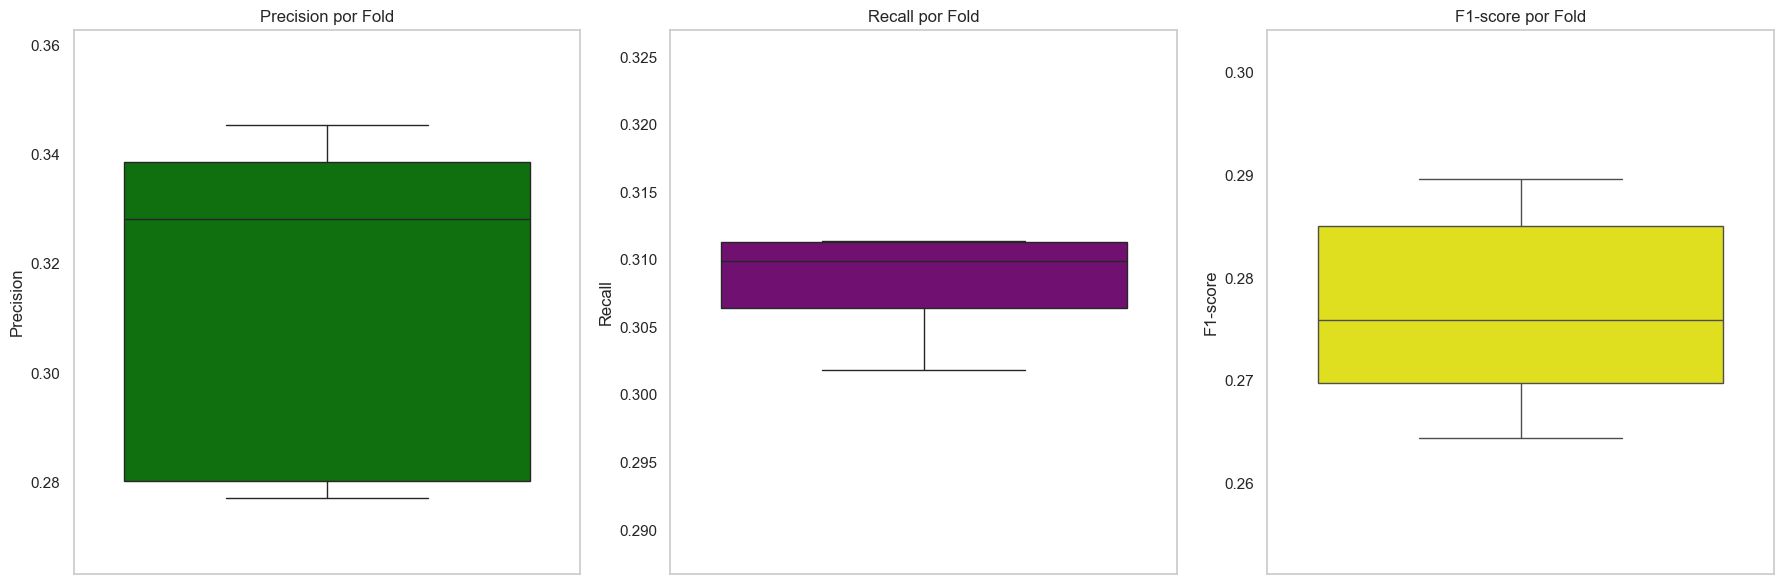

In [38]:
metrics = ['precision', 'recall', 'f1-score']
cores = ['green', 'purple', 'yellow']
plt.figure(figsize=(18, 6))

sns.set(style="whitegrid")

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=metric, data=metrics_df_category, color=cores[i])
    plt.title(f'{metric.capitalize()} por Fold')
    plt.ylabel(metric.capitalize())

    min_val = metrics_df_category[metric].min() * 0.95
    max_val = metrics_df_category[metric].max() * 1.05
    plt.ylim(min_val, max_val)

    plt.grid(False)

plt.tight_layout()

metric_by_fold_categorypoi = '/tmp/metric-by-fold-categorypoi.png'
plt.savefig(metric_by_fold_categorypoi)

plt.show()

#### **Métricas de teste em cada fold**

In [ ]:
for fold in fold_results_test:
  print('"' * 85)
  print(f'FOLD {fold}\n')

  y_true_next = fold_results_test[fold]['test_next_true']
  y_pred_next = fold_results_test[fold]['test_next_pred']

  y_true_category = fold_results_test[fold]['test_category_true']
  y_pred_category = fold_results_test[fold]['test_category_pred']

  print_classification_report_test(y_true_next, y_pred_next, id_to_name, 'next')
  print_classification_report_test(y_true_category, y_pred_category, id_to_name, 'category')
  print()

#### **Evolução das perdas**

##### **Durante o treinamento**

In [ ]:
num_folds = len(fold_losses_train)

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, len(fold_losses_train[fold]['next_losses']) + 1)
    losses = fold_losses_train[fold]['next_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas no Treino por Fold (NPC)')
plt.legend()
plt.grid(True)

next_train_loss_graph = "/tmp/loss-next-by-fold-.png"
plt.savefig(next_train_loss_graph)

plt.show()

In [ ]:
num_folds = len(fold_losses_train)

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, len(fold_losses_train[fold]['category_losses']) + 1)
    losses = fold_losses_train[fold]['category_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas no Treino por Fold (PCat)')
plt.legend()
plt.grid(True)

cat_train_loss_graph = "/tmp/loss-category-by-fold-.png"
plt.savefig(cat_train_loss_graph)

plt.show()

##### **Durante a validação**

In [ ]:
num_folds = len(fold_losses_train)

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, len(fold_losses_val[fold]['next_val_losses']) + 1)
    losses = fold_losses_val[fold]['next_val_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas na Validação por Fold (NPC)')
plt.legend()
plt.grid(True)

next_val_loss_graph = "/tmp/next_val_loss_graph.png"
plt.savefig(next_val_loss_graph)

plt.show()

In [ ]:
num_folds = len(fold_losses_train)

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, len(fold_losses_val[fold]['category_val_losses']) + 1)
    losses = fold_losses_val[fold]['category_val_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas na Validação por Fold (PCat)')
plt.legend()
plt.grid(True)

cat_val_loss_graph = "/tmp/category_val_loss_graph.png"
plt.savefig(cat_val_loss_graph)

plt.show()

### **Salvar resultados no drive**

In [ ]:
model_name_next = 'NPC'
model_name_category = 'PCat'
state = 'alabama'

def _classification_report(y_true, y_pred, id_to_name, fold_num):
    report = classification_report(y_true, y_pred, zero_division=1, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(columns='support')
    metrics_df.rename(index=id_to_name, inplace=True)
    metrics_df = metrics_df.transpose()
    metrics_df = metrics_df.map(lambda x: f"{x * 100:.1f}")
    accuracy = f"{report['accuracy'] * 100:.1f}"

    return metrics_df, accuracy

agg_metrics_list_next = []
metrics_list_next = []

agg_metrics_list_category = []
metrics_list_category = []

for fold in fold_results_test:
    y_true_next = fold_results_test[fold]['test_next_true']
    y_pred_next = fold_results_test[fold]['test_next_pred']
    report_next, accuracy_next = _classification_report(y_true_next, y_pred_next, id_to_name, fold)

    y_true_category = fold_results_test[fold]['test_category_true']
    y_pred_category = fold_results_test[fold]['test_category_pred']
    report_category, accuracy_category = _classification_report(y_true_category, y_pred_category, id_to_name, fold)

    df_metrics_next = report_next.copy()
    df_metrics_next.reset_index(inplace=True)
    df_metrics_next = df_metrics_next.rename(columns={'index': 'Metricas'})
    path_df = f'/tmp/next-metrics-fold{fold}.csv'
    df_metrics_next.to_csv(path_df)

    df_metricscategory = report_category.copy()
    df_metricscategory.reset_index(inplace=True)
    df_metricscategory = df_metricscategory.rename(columns={'index': 'Metricas'})
    path_df = f'/tmp/category-metrics-fold{fold}.csv'
    df_metricscategory.to_csv(path_df)

    # primeiro csv que gera um grafico
    agg_metrics_next = {
        'fold': fold,
        'model': model_name_next,
        'accuracy': accuracy_next,
        'macro avg': report_next.loc['f1-score', 'macro avg'],
        'weighted avg': report_next.loc['f1-score', 'weighted avg'],
        'state': state
    }
    agg_metrics_list_next.append(agg_metrics_next)

    agg_metrics_category = {
        'fold': fold,
        'model': model_name_category,
        'accuracy': accuracy_category,
        'macro avg': report_category.loc['f1-score', 'macro avg'],
        'weighted avg': report_category.loc['f1-score', 'weighted avg'],
        'state': state
    }
    agg_metrics_list_category.append(agg_metrics_category)

    # segundo csv que gera a tabela
    for categoria in report_next.columns:
        if categoria not in ['macro avg', 'weighted avg']:
            next_metrics = {
                'precision': report_next.loc['precision', categoria],
                'recall': report_next.loc['recall', categoria],
                'f1-score': report_next.loc['f1-score', categoria],
                'category': categoria,
                'accuracy': accuracy_next,
                'model': model_name_next,
                'state': state
            }
            metrics_list_next.append(next_metrics)

    for categoria in report_category.columns:
        if categoria not in ['macro avg', 'weighted avg']:
            next_metrics = {
                'precision': report_category.loc['precision', categoria],
                'recall': report_category.loc['recall', categoria],
                'f1-score': report_category.loc['f1-score', categoria],
                'category': categoria,
                'accuracy': accuracy_category,
                'model': model_name_category,
                'state': state
            }
            metrics_list_category.append(next_metrics)

agg_metrics_df_next = pd.DataFrame(agg_metrics_list_next)
category_metrics_next = pd.DataFrame(metrics_list_next)

agg_metrics_df_category = pd.DataFrame(agg_metrics_list_category)
category_metrics_category = pd.DataFrame(metrics_list_category)

In [ ]:
path_agg_metrics_next = f'/content/drive/MyDrive/Graduacao/POC/Dados/models-results/MTLPOIPCGrad/{state}/NPC-general.csv'
path_category_metrics_next = f'/content/drive/MyDrive/Graduacao/POC/Dados/models-results/MTLPOIPCGrad/{state}/NPC-all-metrics.csv'

path_agg_metrics_category = f'/content/drive/MyDrive/Graduacao/POC/Dados/models-results/MTLPOIPCGrad/{state}/PCat-general.csv'
path_category_metrics_category = f'/content/drive/MyDrive/Graduacao/POC/Dados/models-results/MTLPOIPCGrad/{state}/PCat-all-metrics.csv'

In [ ]:
agg_metrics_df_next.to_csv(path_agg_metrics_next, index=False)
category_metrics_next.to_csv(path_category_metrics_next, index=False)

agg_metrics_df_category.to_csv(path_agg_metrics_category, index=False)
category_metrics_category.to_csv(path_category_metrics_category, index=False)

In [ ]:
model_and_train_params = {
  'input_dim': 100,
  'shared_layer_size': 256,
  'num_classes': 7,
  'num_layers': 4,
  'num_heads': 8,
  'seq_length': 9,
  'lr': 0.0001,
  'num_epochs': 100,
  'n_splits': 5,
  'weight_decay': 1e-5,
  'num_shared_layers': 4,
}

In [ ]:
tasks = ['next', 'category']
num_folds = 5
epochs = 50
model_name = 'MTLPOI'

for task in tasks:
    task_losses_train_avg = []
    task_losses_val_avg = []

    for epoch in range(epochs):
        epoch_train_losses = []
        epoch_val_losses = []

        for fold in range(num_folds):
            epoch_train_losses.append(fold_losses_train[fold + 1][f'{task}_losses'][epoch])
            epoch_val_losses.append(fold_losses_val[fold + 1][f'{task}_val_losses'][epoch])

        task_losses_train_avg.append(np.mean(epoch_train_losses))
        task_losses_val_avg.append(np.mean(epoch_val_losses))

    df_losses = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        f'{task}_train_loss_avg': task_losses_train_avg,
        f'{task}_val_loss_avg': task_losses_val_avg
    })

    state = 'alabama'
    task_loss_path = f"/content/drive/MyDrive/Graduacao/POC/GerarResultados/ablation_study/{model_name}_losses_{task}_avg_{state}.csv"
    df_losses.to_csv(task_loss_path, index=False)

    print(f"Arquivo CSV gerado para a tarefa {task} e modelo {model_name}: {task_loss_path}")

### **Salvar resultados no MlFlow**

In [ ]:
mlflow.end_run()

In [ ]:
import tempfile
import os

with mlflow.start_run(run_name='MTL-POI PCGrad'):
    mlflow.log_params(model_and_train_params)
    torch.save(model.state_dict(), "mtlpoi.pth")
    mlflow.log_artifact("mtlpoi.pth", "Modelos")
    mlflow.log_artifact(next_train_loss_graph, "Perdas de Treino")
    mlflow.log_artifact(cat_train_loss_graph, "Perdas de Treino")
    mlflow.log_artifact(next_val_loss_graph, "Perdas de Validação")
    mlflow.log_artifact(cat_val_loss_graph, "Perdas de Validação")
    mlflow.log_artifact(metric_by_fold_nextpoi, "Distribuição das Métricas de Teste")
    mlflow.log_artifact(metric_by_fold_categorypoi, "Distribuição das Métricas de Teste")
    mlflow.log_artifact(path_agg_metrics_next, "Métrica F1-Score (NPC)")
    mlflow.log_artifact(path_agg_metrics_category, "Métrica F1-Score (PCat)")

    with tempfile.TemporaryDirectory() as tmpdir:
        metrics_df_next_path = os.path.join(tmpdir, "metrics_df_next.csv")
        metrics_df_category_path = os.path.join(tmpdir, "metrics_df_category.csv")

        metrics_df_next.to_csv(metrics_df_next_path, index=False)
        metrics_df_category.to_csv(metrics_df_category_path, index=False)

        mlflow.log_artifact(metrics_df_next_path, "Métricas de Teste (NPC)")
        mlflow.log_artifact(metrics_df_category_path, "Métricas de Teste (NPC)")

        for fold in fold_results_test:
            path_df_next = f'/tmp/next-metrics-fold{fold}.csv'
            mlflow.log_artifact(path_df_next, "Métricas de Teste Por Fold (NPC)")

            path_df_category = f'/tmp/category-metrics-fold{fold}.csv'
            mlflow.log_artifact(path_df_category, "Métricas de Teste por Fold (PCat)")